In [1]:
# ============== 1. SETUP AND IMPORTS ==============
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# ============== 2. DATA LOADING ==============
# This section loads the image paths and labels from the directory structure.
images = []
labels = []
# Ensure this path matches the location of your dataset
data_path = './dataset'

# This loop might need adjustment if your directory structure is different
for subfolder in os.listdir(data_path):
    subfolder_path = os.path.join(data_path, subfolder)
    if os.path.isdir(subfolder_path):
        for folder in os.listdir(subfolder_path):
            subfolder_path2 = os.path.join(subfolder_path, folder)
            if os.path.isdir(subfolder_path2):
                for image_filename in os.listdir(subfolder_path2):
                    image_path = os.path.join(subfolder_path2, image_filename)
                    images.append(image_path)
                    labels.append(folder)

df = pd.DataFrame({'image': images, 'label': labels})
print(f"Loaded {len(df)} image paths.")
print(df['label'].value_counts())





Loaded 44000 image paths.
label
NonDemented         12800
VeryMildDemented    11200
ModerateDemented    10000
MildDemented        10000
Name: count, dtype: int64


In [3]:
# ============== 3. DATA SPLITTING ==============
# This creates the train, validation, and test sets.
# Using a fixed random_state ensures the split is the same every time.
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.2, random_state=42, shuffle=True, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42, shuffle=True, stratify=y_test1)

df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

print(f"\nTraining set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Test set size: {len(df_test)}")


Training set size: 35200
Validation set size: 4400
Test set size: 4400


In [4]:
# ============== 4. MODEL TRAINING AND EVALUATION ==============

# Create a new ImageDataGenerator for ResNet50 with its specific preprocessing
resnet_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    horizontal_flip=True
)

# ResNet50 expects 224x224 images
image_size = (224, 224)
batch_size = 32

# Create new generators for training, validation, and testing
print("\nCreating data generators...")
train_generator_resnet = resnet_datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator_resnet = resnet_datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator_resnet = resnet_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Creating data generators...
Found 35200 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.
Found 4400 validated image filenames belonging to 4 classes.


In [5]:
# Load the ResNet50 base model with pre-trained ImageNet weights
print("\nBuilding ResNet50 model...")
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model_resnet.trainable = False

# Add custom classification head
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions_resnet = Dense(4, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)

# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

# Define callbacks
checkpoint_cb_resnet = tf.keras.callbacks.ModelCheckpoint("model_ResNet50.keras", save_best_only=True)
early_stopping_cb_resnet = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


Building ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,694,084 (98.02 MB)

 Trainable params: 2,104,324 (8.03 MB)

 Non-trainable params: 23,589,760 (89.99 MB)

In [6]:
# Train the model
print("\nStarting model training...")
hist_resnet = model_resnet.fit(
    train_generator_resnet,
    epochs=20,
    validation_data=val_generator_resnet,
    callbacks=[checkpoint_cb_resnet, early_stopping_cb_resnet]
)


Starting model training...
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1757197999.646162     104 service.cc:145] XLA service 0x7cb3b4002ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757197999.646216     104 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757197999.646220     104 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   2/1100 ━━━━━━━━━━━━━━━━━━━━ 1:29 82ms/step - accuracy: 0.3672 - loss: 1.7718  

I0000 00:00:1757198007.470596     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1100/1100 ━━━━━━━━━━━━━━━━━━━━ 245s 209ms/step - accuracy: 0.6103 - loss: 1.0007 - val_accuracy: 0.6677 - val_loss: 0.7717
Epoch 2/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 109s 98ms/step - accuracy: 0.6991 - loss: 0.6746 - val_accuracy: 0.7161 - val_loss: 0.6225
Epoch 3/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 112s 102ms/step - accuracy: 0.7233 - loss: 0.6240 - val_accuracy: 0.7480 - val_loss: 0.5720
Epoch 4/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 112s 101ms/step - accuracy: 0.7374 - loss: 0.6073 - val_accuracy: 0.7566 - val_loss: 0.5937
Epoch 5/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 113s 102ms/step - accuracy: 0.7426 - loss: 0.5841 - val_accuracy: 0.7470 - val_loss: 0.5699
Epoch 6/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 112s 102ms/step - accuracy: 0.7498 - loss: 0.5707 - val_accuracy: 0.7470 - val_loss: 0.5715
Epoch 7/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 114s 103ms/step - accuracy: 0.7596 - loss: 0.5569 - val_accuracy: 0.7775 - val_loss: 0.5130
Epoch 8/20
1100/1100 ━━━━━━━━━━━━━━━━━━━━ 112s 102ms/step - accuracy: 0.76

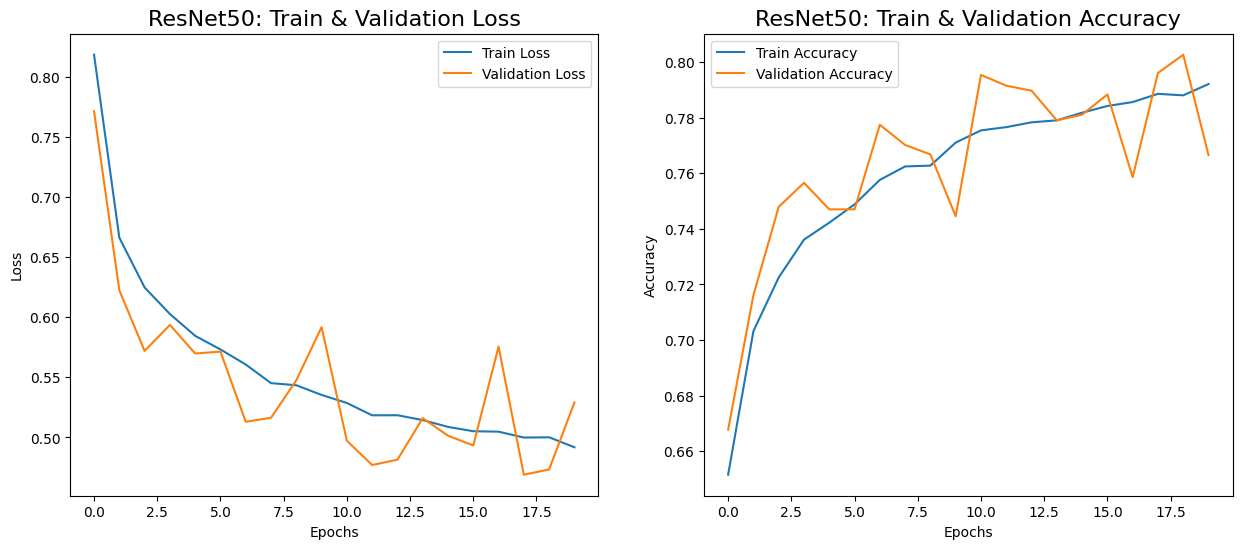


--- ResNet50 Test Set Evaluation ---
138/138 ━━━━━━━━━━━━━━━━━━━━ 24s 170ms/step - accuracy: 0.8073 - loss: 0.4639
Test Loss = 0.466332346200943
Test Accuracy = 0.8002272844314575
138/138 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step

--- ResNet50 Classification Report ---
                  precision    recall  f1-score   support

    MildDemented       0.83      0.72      0.77      1000
ModerateDemented       0.99      1.00      0.99      1000
     NonDemented       0.79      0.78      0.78      1280
VeryMildDemented       0.65      0.73      0.68      1120

        accuracy                           0.80      4400
       macro avg       0.81      0.81      0.81      4400
    weighted avg       0.81      0.80      0.80      4400



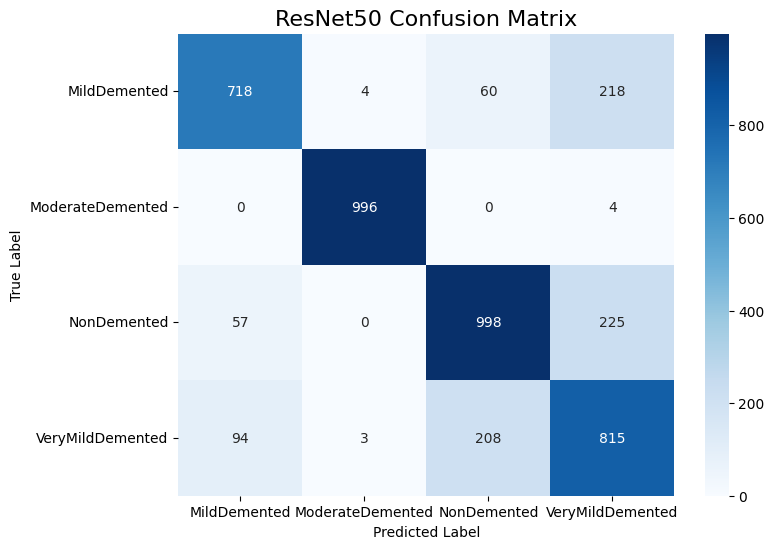

In [7]:
# Plot training and validation curves for ResNet50
hist_resnet_df = pd.DataFrame(hist_resnet.history)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hist_resnet_df['loss'], label='Train Loss')
plt.plot(hist_resnet_df['val_loss'], label='Validation Loss')
plt.title('ResNet50: Train & Validation Loss', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist_resnet_df['accuracy'], label='Train Accuracy')
plt.plot(hist_resnet_df['val_accuracy'], label='Validation Accuracy')
plt.title('ResNet50: Train & Validation Accuracy', fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on the test set
print("\n--- ResNet50 Test Set Evaluation ---")
score_resnet, acc_resnet = model_resnet.evaluate(test_generator_resnet)
print('Test Loss =', score_resnet)
print('Test Accuracy =', acc_resnet)

# Generate predictions
predictions_resnet = model_resnet.predict(test_generator_resnet)
y_pred_resnet = np.argmax(predictions_resnet, axis=1)
y_test_resnet = test_generator_resnet.classes

# Get the class names as a list of strings
class_names = list(test_generator_resnet.class_indices.keys())

# Print the classification report using the correct string labels
print("\n--- ResNet50 Classification Report ---")
print(classification_report(y_test_resnet, y_pred_resnet, target_names=class_names))

# Plot confusion matrix
cm_resnet = confusion_matrix(y_test_resnet, y_pred_resnet)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [8]:
# ============== 5. SAVE RESULTS ==============
# Save the training history to a CSV file
hist_df_resnet = pd.DataFrame(hist_resnet.history)
hist_df_resnet.to_csv('history_resnet50.csv', index=False)

# Save the predictions to a numpy file
np.save('predictions_resnet50.npy', predictions_resnet)

print("\nResNet50 results saved successfully!")


ResNet50 results saved successfully!
